In [2]:
import os
import librosa   #for audio processing
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

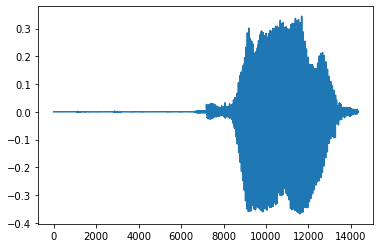

In [3]:
train_audio_path = 'C:\\Users\\ASUS\\aud\\train\\'
samples, sample_rate = librosa.load(train_audio_path+'0\\0ab3b47d_nohash_0.wav', sr = 16000)
plt.plot(samples)
plt.show()

In [4]:
ipd.Audio(samples, rate=sample_rate)
print(sample_rate)

16000


In [5]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

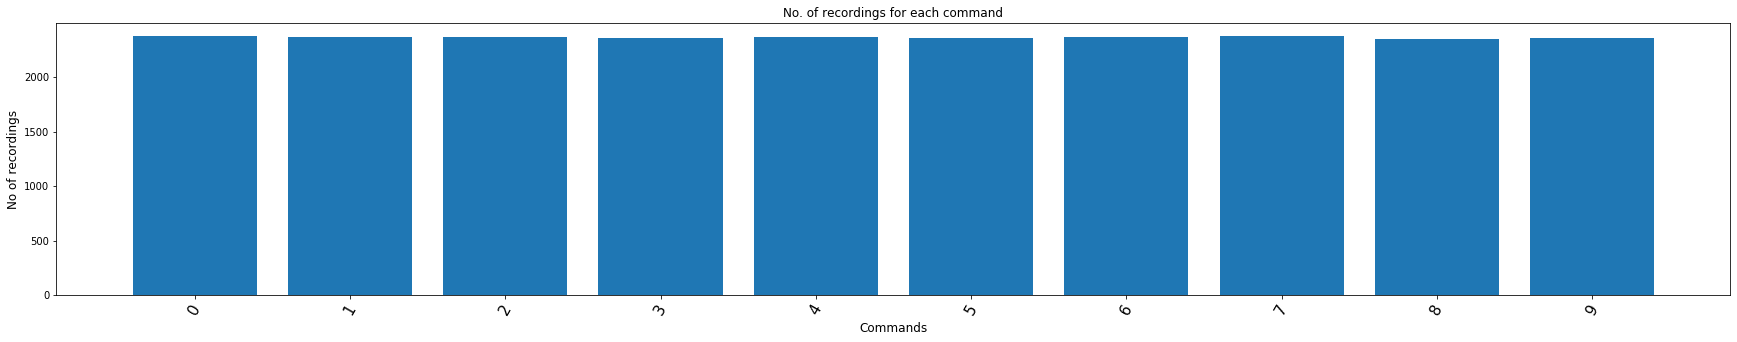

In [6]:
labels=os.listdir(train_audio_path)

#find count of each label and plot bar graph
no_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

labels=["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

(array([7.0000e+00, 3.0000e+00, 6.5000e+01, 5.8000e+01, 1.2300e+02,
        1.9600e+02, 3.1200e+02, 2.6500e+02, 4.3900e+02, 2.2198e+04]),
 array([0.3715625 , 0.43440625, 0.49725   , 0.56009375, 0.6229375 ,
        0.68578125, 0.748625  , 0.81146875, 0.8743125 , 0.93715625,
        1.        ]),
 <a list of 10 Patch objects>)

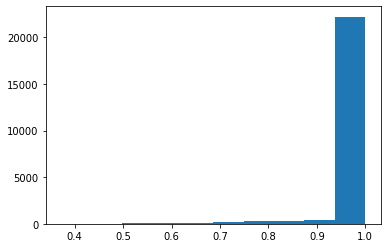

In [7]:

duration_of_recordings=[]
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '\\'+ label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '\\' + label + '\\' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))
    
plt.hist(np.array(duration_of_recordings))

In [43]:
train_audio_path = 'C:\\Users\\ASUS\\aud\\train\\'

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '\\'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '\\' + label + '\\' + wav, sr = 16000)
        mfcc = librosa.feature.mfcc(samples, sr=8000)
        pad_width = 40 - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='mean') 
        all_wave.append(mfcc)
        all_label.append(label)

0
1
2
3
4
5
6
7
8
9


In [54]:
all_wave=np.asarray(all_wave)
print(np.shape(all_wave))
dim_1 = np.shape(all_wave)[1]
dim_2 = np.shape(all_wave)[2]
channels = 1
classes = 10
all_wave = all_wave.reshape((all_wave.shape[0], dim_1, dim_2, channels))
input_shape = (dim_1, dim_2, channels)

(23666, 20, 40)


In [56]:
#plt.imshow(all_wave[0])

In [57]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y=le.fit_transform(all_label)
classes= list(le.classes_)

In [58]:
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))

In [59]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.1,random_state=777,shuffle=True)

In [60]:
x_tr.shape

(21299, 20, 40, 1)

In [61]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization

num_classes=len(classes)

model = Sequential()

model.add(Conv2D(32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())

model.add(Conv2D(48, kernel_size=(2, 2), activation='relu'))
model.add(BatchNormalization())

model.add(Conv2D(120, kernel_size=(2, 2), activation='relu'))
model.add(BatchNormalization())

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.23))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.23))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.23))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 19, 39, 32)        160       
_________________________________________________________________
batch_normalization_13 (Batc (None, 19, 39, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 18, 38, 48)        6192      
_________________________________________________________________
batch_normalization_14 (Batc (None, 18, 38, 48)        192       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 17, 37, 120)       23160     
_________________________________________________________________
batch_normalization_15 (Batc (None, 17, 37, 120)       480       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 18, 120)       

In [62]:
import keras
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])

In [63]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model1.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [64]:
history=model.fit(x_tr, y_tr ,epochs=50, callbacks=[es,mc], batch_size=64, validation_data=(x_val,y_val))
model.save('best_model1.hdf5')


Train on 21299 samples, validate on 2367 samples
Epoch 1/50
21299/21299 [==============================] - 498s 23ms/step - loss: 1.2089 - accuracy: 0.6007 - val_loss: 0.8533 - val_accuracy: 0.7195
Epoch 2/50
21299/21299 [==============================] - 493s 23ms/step - loss: 0.5979 - accuracy: 0.8139 - val_loss: 0.4374 - val_accuracy: 0.8610
Epoch 3/50
21299/21299 [==============================] - 437s 20ms/step - loss: 0.3985 - accuracy: 0.8803 - val_loss: 0.3379 - val_accuracy: 0.8893
Epoch 4/50
21299/21299 [==============================] - 421s 20ms/step - loss: 0.3054 - accuracy: 0.9068 - val_loss: 0.3014 - val_accuracy: 0.9054
Epoch 5/50
21299/21299 [==============================] - 488s 23ms/step - loss: 0.2374 - accuracy: 0.9276 - val_loss: 0.2365 - val_accuracy: 0.9256
Epoch 6/50
21299/21299 [==============================] - 832s 39ms/step - loss: 0.2062 - accuracy: 0.9380 - val_loss: 0.2826 - val_accuracy: 0.9210
Epoch 7/50
21299/21299 [==============================] 

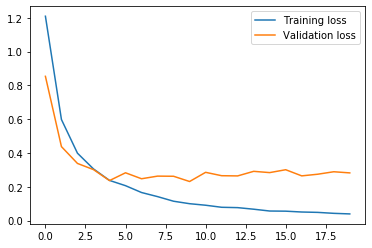

In [65]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='Training loss') 
pyplot.plot(history.history['val_loss'], label='Validation loss') 
pyplot.legend() 
pyplot.show()

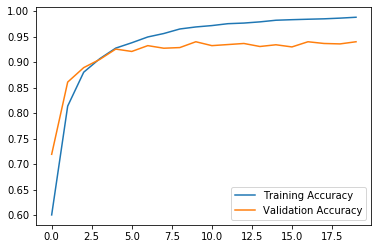

In [66]:
pyplot.plot(history.history['accuracy'], label='Training Accuracy') 
pyplot.plot(history.history['val_accuracy'], label='Validation Accuracy') 
pyplot.legend() 
pyplot.show()